In [1]:
import os
import time

from importlib import reload

import pickle as pk
import pandas as pd

import numpy as np
from scipy.stats import norm as norm_dist

from sklearn.cluster import KMeans
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed

#sys.path.extend([os.getcwd()])

from calibre.model import gaussian_process as gp
from calibre.model import tailfree_process as tail_free
from calibre.model import gp_regression_monotone as gpr_mono
from calibre.model import adaptive_ensemble

from calibre.inference import mcmc

from calibre.calibration import score

import calibre.util.misc as misc_util
import calibre.util.metric as metric_util
import calibre.util.visual as visual_util
import calibre.util.matrix as matrix_util
import calibre.util.ensemble as ensemble_util
import calibre.util.calibration as calib_util

import calibre.util.experiment_pred as pred_util

from calibre.util.inference import make_value_setter

import matplotlib.pyplot as plt
import seaborn as sns


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
AV_US = pd.read_csv("all_models/AV_2010_2016_align.csv")

In [3]:
AV_US_2016 = AV_US[AV_US.time==2016]

In [4]:
AV_US_2016.head()

,lon,lat,time,pm25
48706878,-95.095,49.295,2016,3.0
48706879,-95.085,49.295,2016,3.0
48706880,-95.075,49.295,2016,3.0
48706881,-95.065,49.295,2016,3.0
48706882,-95.055,49.295,2016,3.0


In [5]:
AV_US_2016.shape

(8117813, 4)

In [6]:
GS_US = pd.read_csv("all_models/GS_2010_2016_align.csv")

In [7]:
GS_US_2016 = GS_US[GS_US.time==2016]

In [8]:
GS_US_2016.head()

,lon,lat,time,pm25
48706878,-95.095,49.295,2016,6.008982
48706879,-95.085,49.295,2016,6.008982
48706880,-95.075,49.295,2016,6.008982
48706881,-95.065,49.295,2016,6.008982
48706882,-95.055,49.295,2016,6.008982


In [9]:
GS_US_2016.shape

(8117813, 4)

In [10]:
SC_US = pd.read_csv("all_models/SC_2010_2016_align.csv")

In [11]:
SC_US_2016 = SC_US[SC_US.time==2016]

In [12]:
SC_US_2016.head()

,lon,lat,time,pm25
48706878,-95.095,49.295,2016,7.939744
48706879,-95.085,49.295,2016,7.939744
48706880,-95.075,49.295,2016,7.939744
48706881,-95.065,49.295,2016,7.939744
48706882,-95.055,49.295,2016,7.939744


In [13]:
SC_US_2016.shape

(8117813, 4)

In [14]:
X_train = pd.read_csv("all_models/training_2010_2016.csv")

In [15]:
X_train.head()

,time,lon,lat,pm25_obs,pred_AV,pred_SC,pred_GS
0,2010,-124.083900,41.560800,2.835678,3.4,4.578975,5.364638
1,2010,-124.058900,42.552000,2.970706,3.3,4.419969,4.742808
2,2010,-123.348466,42.434139,6.405263,6.6,13.098448,6.467641
3,2010,-123.139831,44.066304,6.289076,5.8,7.118291,7.146530
4,2010,-123.083737,44.026312,5.686517,5.9,12.025641,6.839928


In [16]:
X_train_US_2016 = X_train[X_train.time==2016]

# Changes I made in visual.py

line 612 -> figsize from (10,8) to (15,8)
line 625& 626 - commented out 

In [17]:
AV_US_2016['pm25'].describe()

count    8.117813e+06
mean     5.396070e+00
std      1.925534e+00
min      1.700000e+00
25%      3.800000e+00
50%      5.100000e+00
75%      7.000000e+00
max      1.650000e+01
Name: pm25, dtype: float64

In [18]:
SC_US_2016['pm25'].describe()

count    8.117813e+06
mean     9.276140e+00
std      5.073778e+00
min     -4.916766e-01
25%      6.511864e+00
50%      8.198214e+00
75%      1.029527e+01
max      6.013055e+01
Name: pm25, dtype: float64

In [19]:
max(SC_US_2016['pm25'])

60.13055

In [20]:
GS_US_2016['pm25'].describe()

count    8.117813e+06
mean     7.639032e+00
std      1.589585e+00
min      3.654308e+00
25%      6.371464e+00
50%      7.414586e+00
75%      8.757052e+00
max      1.889925e+01
Name: pm25, dtype: float64

In [170]:
#bounding box 
min_lon = -124.409591
max_lon = -114.131211
min_lat = 32.534156
max_lat = 42.009518


In [193]:
def filter_state(df):
    out = df[(df.lat>=min_lat) & (df.lat<=max_lat) & \
    (df.lon>=min_lon) & (df.lon<=max_lon)]
    
    return out 
    

In [198]:
X_train_US_2016_state = filter_state(X_train_US_2016)

In [194]:
AV_US_2016_state = filter_state(AV_US_2016)

In [195]:
GS_US_2016_state = filter_state(GS_US_2016)

In [196]:
SC_US_2016_state = filter_state(SC_US_2016)

In [141]:
# AV_2016_US_original = pd.read_csv('all_models/AV_2016_align.csv')
# GBD_2016_US_original = pd.read_csv('all_models/GBD_2016_align.csv')
# SC_2016_US_original = pd.read_csv('all_models/scott_2016_align.csv')

In [156]:
# AV_US_2016_state_original = filter_state(AV_2016_US_original)
# GBD_US_2016_state_original = filter_state(GBD_2016_US_original)
# SC_US_2016_state_original = filter_state(SC_2016_US_original)

In [177]:
import shapefile as shp  # Requires the pyshp package
sf = shp.Reader('tl_2017_us_state/tl_2017_us_state.shp')


In [191]:
state_sf = np.take(sf.shapeRecords(), sf_df[sf_df[5].isin(['CA', 'NV', 'AZ'])].index)

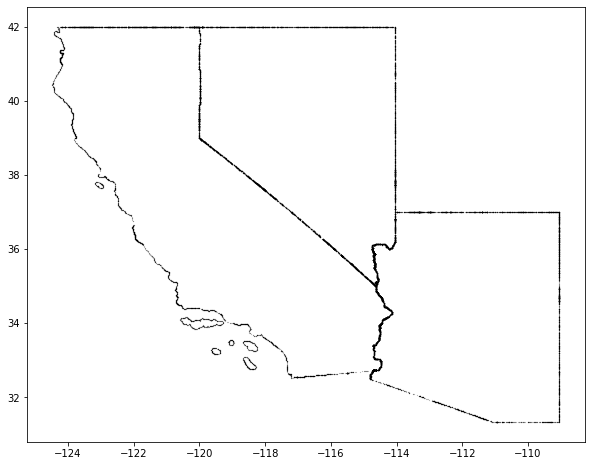

In [192]:
plt.figure(figsize=(10, 8))
for shape in state_sf:
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.scatter(x,y,color='black',s=0.01)
plt.show()

In [203]:
color_norm_pred = visual_util.make_color_norm(
        np.array([4, 10]),  # exclude "resid" vales from pal
        method="percentile")


save_name ='all_models/GS_US_2016_CA.png'
plot_data = GS_US_2016_state['pm25']
X=GS_US_2016_state[['lon', 'lat']].values
X_monitor=X_train_US_2016_state[['lon','lat']].values
cmap=plt.get_cmap('RdYlGn_r')
norm=color_norm_pred
norm_method="percentile"
save_addr=save_name

In [204]:
# 2d color plot using scatter
# made changes here on the fig size
plt.figure(figsize=(10, 8))
plt.scatter(x=X[:, 0], y=X[:, 1],
                s=3,
                c=plot_data, cmap=cmap, norm=norm)
cbar = plt.colorbar()

# plot monitors
if isinstance(X_monitor, np.ndarray):
    plt.scatter(x=X_monitor[:, 0], y=X_monitor[:, 1],
                    s=10, c='black')

# adjust plot window
plt.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
plt.ylim((np.min(X[:, 1]), np.max(X[:, 1])))


#overlap the state borders
for shape in state_sf:
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.scatter(x,y,color='black',s=0.01)

if save_addr:
    plt.savefig(save_addr, bbox_inches='tight')
    plt.close()
    plt.ion()
else:
    plt.show()

In [38]:
# color_norm_pred = visual_util.make_color_norm(
#         np.array([4, 14]),  # exclude "resid" vales from pal
#         method="percentile")


# save_name = 'all_models/SC_US_2016_state.png'
# color_norm = visual_util.posterior_heatmap_2d(SC_US_2016_state['pm25'],
#                                                       X=SC_US_2016_state[['lon', 'lat']].values, \
#                                               X_monitor=X_train_US_2016_state[['lon','lat']].values,
#                                                       cmap='RdYlGn_r',
#                                                       norm=color_norm_pred,
#                                                       norm_method="percentile",
#                                                       save_addr=save_name)

